### Notebook to generate Supp Figure 5B

In [1]:
## import statement

import matplotlib
from matplotlib import pyplot as plt
import seaborn
import scanpy
import pandas
from typing import Tuple, Any, List, Union
import numpy as np
import torch
import os
from anndata import read_h5ad
from scanpy import pp
import pandas as pd
import umap
import scanpy as sc
import random
import pickle

# tissue_purifier import
import tissue_purifier as tp

In [2]:
from tissue_purifier.genex.gene_utils import *
from tissue_purifier.genex.poisson_glm import *
from tissue_purifier.utils import *
from tissue_purifier.plots import *

In [3]:
## pytorch

torch.cuda.set_device(0)
torch.set_default_tensor_type(torch.FloatTensor)

/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [4]:
## set seeds
r_seed=t_seed=n_seed=100

random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)



In [5]:
## plotting parameters

linewidth = 5
tickfontsize = 80
labelfontsize = 80
labelpad = 40
titlefontsize=80
legendfontsize=80
legendmarkersize=4

In [6]:
## Set working directory

import os
os.chdir("/home/skambha6/chenlab/tissue_purifier/TissueMosaic_Figures/Supp_Figure5/plots")

In [7]:
patch_cluster_dir = "/home/skambha6/chenlab/tissue_purifier/tp_output/testis/testis_patch_clusters"

# Make a list of all the h5ad files in the annotated_anndata_dest_folder
fname_list = []
for f in os.listdir(patch_cluster_dir):
    if f.endswith('.h5ad'):
        fname_list.append(f)
print(fname_list)

adatas = []

for i in range(len(fname_list)):
        
    fname = fname_list[i]

    # open adata and convert to sparse_image
    adata_path = os.path.join(patch_cluster_dir, fname)
    adata = read_h5ad(adata_path)
    adatas.append(adata)

['wt3_dm.h5ad', 'wt1_dm.h5ad', 'diabetes2_dm.h5ad', 'wt2_dm.h5ad', 'diabetes1_dm.h5ad', 'diabetes3_dm.h5ad']


In [8]:
## take one sample anndata

sample_adata = adatas[5]

## filter/preprocess

### filter
import numpy

sample_adata.obs["cell_id"] = numpy.arange(sample_adata.shape[0])
sample_adata.var["gene_id"] = numpy.arange(sample_adata.shape[1])

sample_adata.var['mt'] = sample_adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(sample_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pp.filter_cells(sample_adata, min_genes=200)
sc.pp.filter_genes(sample_adata, min_cells=3)
sample_adata = sample_adata[sample_adata.obs.pct_counts_mt < 5, :]  # you do not want cells with too much MT in it.
sample_adata = sample_adata[sample_adata.obs.n_genes_by_counts < 2500, :]  # you do not want to cells with too many genes in it. Why?

sc.pp.normalize_total(sample_adata, target_sum=500)
      
sc.pp.log1p(sample_adata)
sc.pp.highly_variable_genes(sample_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

sample_adata = sample_adata[:, sample_adata.var.highly_variable]
sc.pp.regress_out(sample_adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(sample_adata, max_value=10)



/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [9]:
micro_labels_01 = numpy.argmax(sample_adata.obsm["leiden_feature_dino_res_0.2_one_hot"], axis=-1)

sample_adata.obs["micro_labels_res_0.2"] = pandas.Categorical(micro_labels_01)

for key in ["leiden_feature_dino_res_0.2_one_hot"]:
    value = sample_adata.obsm[key]
    n_env = value.shape[-1]
    for n in range(n_env):
        sample_adata.obs['microenv_'+key+'_'+str(n)] = value[:,n] 

In [10]:
sample_adata.obs['cell_type'] = sample_adata.obsm['cell_type_proportions'].idxmax(axis='columns')

In [11]:
sc.pp.neighbors(sample_adata, n_neighbors=50, n_pcs=30)  # Compute neighbors
sc.tl.umap(sample_adata)  # Compute UMAP embedding

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [12]:
for k in range(sample_adata.obsm['cell_type_proportions'].shape[1]):
    ct = np.array(sample_adata.obsm['cell_type_proportions'].columns)[k]
    sample_adata.obs[ct + "_proportion"] = sample_adata.obsm['cell_type_proportions'][ct]

In [15]:
ES_label = np.array(sample_adata.obs['cell_type'].copy())
ES_label[ES_label != "ES"] = "na"
sample_adata.obs['ES_label'] = ES_label

ES_clusters = np.array(sample_adata.obs['micro_labels_res_0.2'].copy())
ES_clusters[ES_label != "ES"] = 4
sample_adata.obs['ES_clusters'] = pd.Categorical(ES_clusters)



In [16]:
RS_label = np.array(sample_adata.obs['cell_type'].copy())
RS_label[RS_label != "RS"] = "na"
sample_adata.obs['RS_label'] = RS_label

RS_clusters = np.array(sample_adata.obs['micro_labels_res_0.2'].copy())
RS_clusters[RS_label != "RS"] = 4
sample_adata.obs['RS_clusters'] = pd.Categorical(RS_clusters)

In [17]:
SPC_label = np.array(sample_adata.obs['cell_type'].copy())
SPC_label[SPC_label != "SPC"] = "na"
sample_adata.obs['SPC_label'] = SPC_label

SPC_clusters = np.array(sample_adata.obs['micro_labels_res_0.2'].copy())
SPC_clusters[SPC_label != "SPC"] = 4
sample_adata.obs['SPC_clusters'] = pd.Categorical(SPC_clusters)

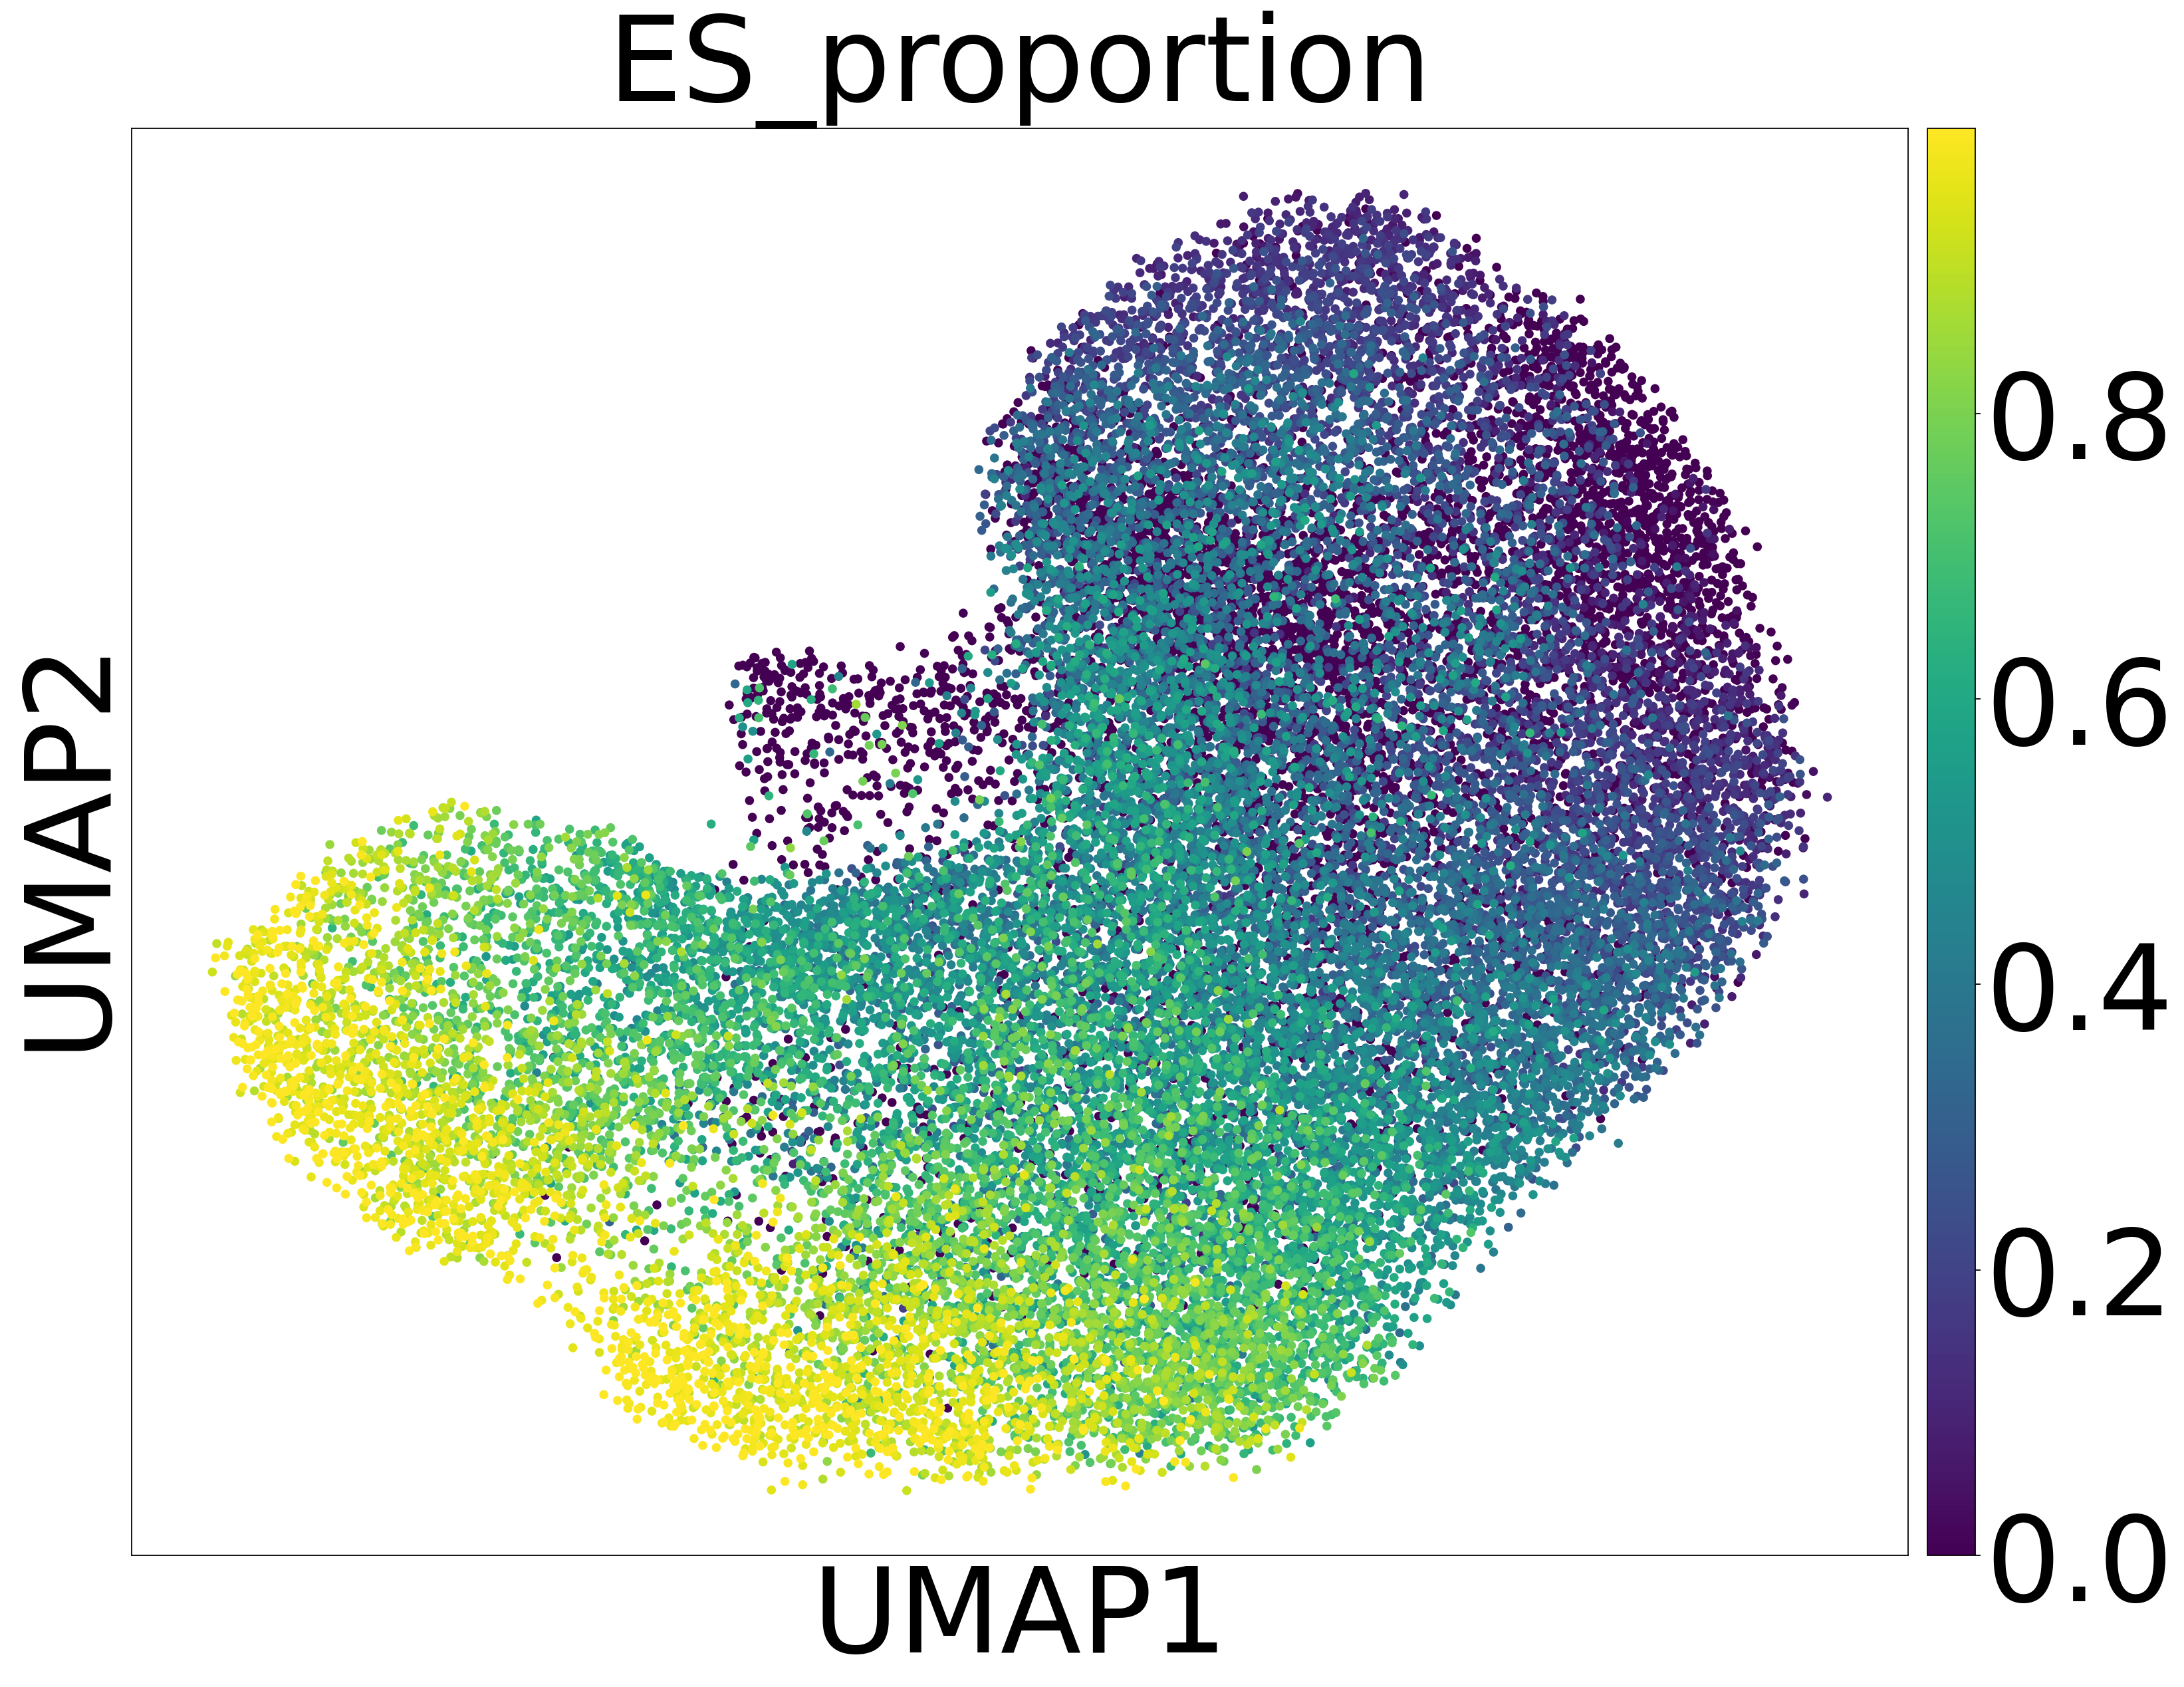

<Figure size 320x320 with 0 Axes>

<Figure size 320x320 with 0 Axes>

/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/scanpy/plotting/

<Figure size 320x320 with 0 Axes>

In [22]:
## gridspec

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import scanpy as sc

# Set vector-friendly plotting parameters
sc.set_figure_params(vector_friendly=True, dpi=300)

sc.set_figure_params(fontsize=legendfontsize)

# Now, when you create plots with Scanpy, they will be optimized for vector formats.

s = 150

# Create a figure
fig = plt.figure(figsize=(80, 60))
# plt.tight_layout()
# Create a 3x3 grid
gs = GridSpec(3, 3, figure=fig)

# Iterate over the grid and create subplots
for i in range(3):
    for j in range(3):
        ax = fig.add_subplot(gs[i, j])
        if j == 0:
            ctype = "ES"
        if j == 1:
            ctype = "RS"
        if j == 2:
            ctype = "SPC"
        if i == 0:
            sc.pl.umap(sample_adata, color=[ctype+ '_proportion'], ax=ax, s=s)
        if i == 1:
            sc.pl.umap(sample_adata, color=[ctype + '_label'], palette={'ES': "tab:blue", 'RS': "tab:red", 'SPC': "tab:purple", 'na': "#D3D3D3"}, ax=ax, s=s)
        if i == 2:
            sc.pl.umap(sample_adata, color=[ctype + '_clusters'], palette={0: "tab:cyan", 1:"tab:orange", 2:"tab:green", 3:"tab:red",4: "#D3D3D3"}, ax=ax, s=s)

        if i == 2:
            if j == 0 or j == 1:
                ax.get_legend().remove()
        if i == 1:
            ax.get_legend().remove()
        
        # Change font sizes
        if i == 0:
            ax.set_title(ctype + ' ' + 'Proportion')
        if i == 1:
            ax.set_title(ctype + ' ' + 'Majority Cell Type')
        if i == 2:
            ax.set_title(ctype + ' ' + 'Spatial Clusters')
        ax.title.set_fontsize(titlefontsize)
        ax.xaxis.label.set_fontsize(labelfontsize)
        ax.yaxis.label.set_fontsize(labelfontsize)
        ax.tick_params(axis='both', labelsize=tickfontsize)
        if ax.get_legend() is not None:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=legendfontsize, frameon=False, markerscale=legendmarkersize)

        if ax.collections[-1].colorbar is not None: 
            ax.collections[-1].colorbar.ax.tick_params(labelsize=tickfontsize)

# Adjust the layout and show the plot
plt.subplots_adjust(wspace=1.0)
fig.savefig('Supp_fig_5b.pdf', transparent=True, bbox_inches='tight', dpi=300)
# plt.show()
